This notebook demonstrates use of our linear approximation for a multiplicative functional perturbation 

In [1]:
import jax
from jax import numpy as np
from jax import scipy as sp

from numpy.polynomial.hermite import hermgauss

import paragami

# BNP sensitivity libraries
import bnpgmm_runjingdev.gmm_clustering_lib as gmm_lib
import bnpgmm_runjingdev.gmm_cavi_lib as cavi_lib
from bnpgmm_runjingdev import utils_lib

from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation
import bnpmodeling_runjingdev.functional_sensitivity_lib as func_sens_lib 
from bnpmodeling_runjingdev import cluster_quantities_lib as cluster_lib


import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA

from copy import deepcopy

import vittles
from tqdm import tqdm

import json 

/home/rliu/anaconda3/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
# colors for plotting
import matplotlib.cm as cm

cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(12)]
colors2 = [cmap(k * 25) for k in range(12)]

# Load data

We load and plot the iris dataset

In [3]:
# load iris data
dataset_name = 'iris'
features, iris_species = utils_lib.load_data()
dim = features.shape[1]
n_obs = len(iris_species)    

Text(0, 0.5, 'PC2')

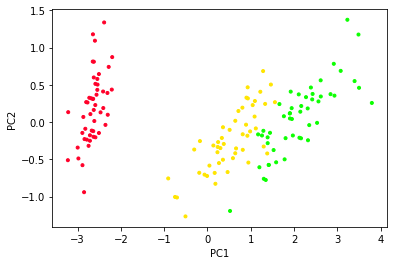

In [4]:
# run PCA
pca_fit = PCA()
pca_fit.fit(features)
pc_features = pca_fit.transform(features)

# plot
cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(30)]

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')


# Load model

### Get prior 

In [5]:
prior_params_dict, prior_params_paragami = gmm_lib.get_default_prior_params(dim)

In [6]:
print(prior_params_dict)

{'alpha': DeviceArray([3.], dtype=float64), 'prior_centroid_mean': DeviceArray([0.], dtype=float64), 'prior_lambda': DeviceArray([1.], dtype=float64), 'prior_wishart_df': DeviceArray([10.], dtype=float64), 'prior_wishart_rate': DeviceArray([[1., 0., 0., 0.],
             [0., 1., 0., 0.],
             [0., 0., 1., 0.],
             [0., 0., 0., 1.]], dtype=float64)}


In [7]:
# DP prior parameter 
prior_params_dict['alpha'] = 12

### Variational parameters

In [8]:
k_approx = 30

In [9]:
# Gauss-Hermite points
gh_deg = 20
gh_loc, gh_weights = hermgauss(gh_deg)


In [10]:
# get vb parameters
vb_params_dict, vb_params_paragami = gmm_lib.get_vb_params_paragami_object(dim, k_approx)

In [11]:
# the objective 
gmm_lib.get_kl(features, vb_params_dict, prior_params_dict, gh_loc, gh_weights)

DeviceArray(-419610.52440416, dtype=float64)

# Optimize

### Kmeans

In [12]:
n_kmeans_init = 1
init_vb_free_params, init_vb_params_dict, init_ez = \
    utils_lib.cluster_and_get_k_means_inits(features, vb_params_paragami, 
                                                n_kmeans_init = n_kmeans_init, 
                                                seed = 32423)

In [13]:
get_kl_flattened = paragami.FlattenFunctionInput(
                        gmm_lib.get_kl,
                        argnums=1,
                        patterns=vb_params_paragami, 
                        free=True)

get_kl_flattened = jax.jit(get_kl_flattened)

# kl time

In [23]:
import time

In [24]:
t0 = time.time()
get_kl_flattened(features, init_vb_free_params, prior_params_dict, gh_loc, gh_weights)
print(time.time() - t0)

0.0021762847900390625


In [25]:
t0 = time.time()
get_kl_flattened(features, init_vb_free_params, prior_params_dict, gh_loc, gh_weights)
print(time.time() - t0)

0.001377105712890625


# Grad time

In [26]:
get_kl_grad = jax.jit(jax.grad(get_kl_flattened, argnums = 1))

In [27]:
t0 = time.time()
get_kl_grad(features, init_vb_free_params, prior_params_dict, gh_loc, gh_weights)
print(time.time() - t0)

7.173100233078003


In [28]:
t0 = time.time()
get_kl_grad(features, init_vb_free_params, prior_params_dict, gh_loc, gh_weights)
print(time.time() - t0)

0.004105091094970703


# Hessian time

In [29]:
get_kl_hess = jax.jit(jax.hessian(get_kl_flattened, argnums = 1))

In [30]:
t0 = time.time()
get_kl_hess(features, init_vb_free_params, prior_params_dict, gh_loc, gh_weights)
print(time.time() - t0)

15.147400379180908


In [31]:
t0 = time.time()
get_kl_hess(features, init_vb_free_params, prior_params_dict, gh_loc, gh_weights)
print(time.time() - t0)

0.0026214122772216797
